# Importing the necessary libraries

In [1]:
import csv
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import Sequential
from keras.layers import Dense
from ann_visualizer.visualize import ann_viz

# Importing Data

In [2]:
# open the csv file and read it
data = pd.read_csv('diabetes_data_upload.csv')

# Exploratory data analysis (EDA)

In [3]:
# display data
data

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [4]:
# Display the Complete Meta-Data of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [5]:
# Checking if there is any null in the dataset
data.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [6]:
# plotting the counts in respect to Gender, Obesity and class
# fig1 = px.sunburst(data, path=['Gender','Obesity', 'class'], width=500, height=500, title='Gender-Obesity-Class')
# fig1.show()

In [7]:
#  plotting  class in respect to Gender and Age
# fig2 = px.histogram(data, x="Age", color="class", width=600, height=400, facet_col='Gender')
# fig2.show()

### Modifying data

In [8]:
modData = data.copy()
# discretizing the Age data into three groups, based on the medical opinion for diabetes
modData['Age'] = modData['Age'].mask(modData['Age'] < 40, 1)
modData['Age'] = modData['Age'].mask(modData['Age'] >= 65, 3)
modData['Age'] = modData['Age'].mask(modData['Age'] >= 40, 2)

In [9]:
# convert binary string data into 1 and 0 
modData = modData.mask(modData == 'Yes', 1)
modData = modData.mask(modData == 'No', 0)
modData = modData.mask(modData == 'Male', 1)
modData = modData.mask(modData == 'Female', 0)
modData = modData.mask(modData == 'Positive', 1)
modData = modData.mask(modData == 'Negative', 0)
modData.iloc[:,:] = modData.iloc[:,:].astype(int)

In [10]:
# display data after modifying it
modData

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,2,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,2,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,2,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,2,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,2,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,2,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


C:\Users\user\AppData\Local\Temp/ipykernel_19232/260796056.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  [modData[modData[modData.columns[counter]] == 1][modData['class'] == 1].count()[0],
C:\Users\user\AppData\Local\Temp/ipykernel_19232/260796056.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  modData[modData[modData.columns[counter]] == 1][modData['class'] == 0].count()[0],
C:\Users\user\AppData\Local\Temp/ipykernel_19232/260796056.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  modData[modData[modData.columns[counter]] == 0][modData['class'] == 1].count()[0],
C:\Users\user\AppData\Local\Temp/ipykernel_19232/260796056.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  modData[modData[modData.columns[counter]] == 0][modData['class'] == 0].count()[0]],


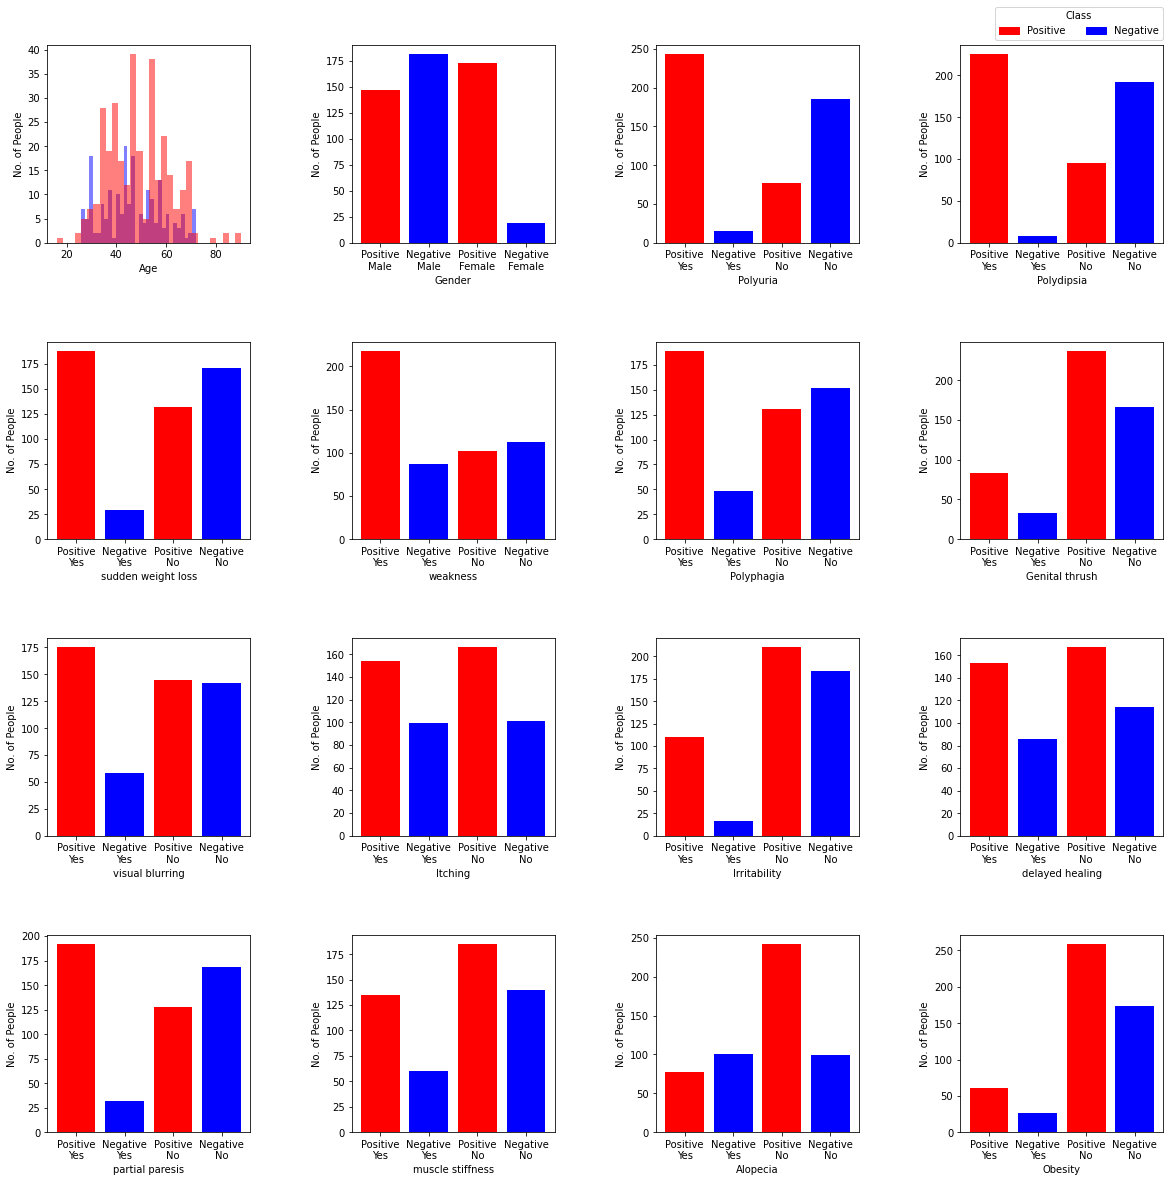

In [11]:
# Visualizing each Feature
figure, axis = plt.subplots(4, 4, figsize=(20,20))


axis[0, 0].hist(data['Age'][data['class'] == 'Negative'], alpha=0.5, bins = 30, histtype ='bar', color = 'blue')
axis[0, 0].hist(data['Age'][data['class'] == 'Positive'], alpha=0.5, bins = 30, histtype ='bar', color = 'red')
axis[0, 0].set_xlabel("Age")
axis[0, 0].set_ylabel('No. of People')

legendElements = [Patch(facecolor='red', edgecolor='red', label='Positive'),
                 Patch(facecolor='blue', edgecolor='blue', label='Negative')]
yes = 'Yes'
no = 'No'
counter = 0
for i in range(4):
    for j in range(4):
        if i == j == 0:
            counter += 1
            continue
        if i == 0 and j == 1:
            yes = 'Male'
            no = 'Female'
        axis[i, j].bar(['Positive\n' + yes, 'Negative\n' + yes, 'Positive\n' + no, 'Negative\n' + no],
                       [modData[modData[modData.columns[counter]] == 1][modData['class'] == 1].count()[0],
                        modData[modData[modData.columns[counter]] == 1][modData['class'] == 0].count()[0],
                        modData[modData[modData.columns[counter]] == 0][modData['class'] == 1].count()[0],
                        modData[modData[modData.columns[counter]] == 0][modData['class'] == 0].count()[0]],
                       color = ['red', 'blue', 'red', 'blue'], width = 0.8)
        axis[i, j].set_xlabel(modData.columns[counter])
        axis[i, j].set_ylabel('No. of People')
        if i == 0 and j == 1:
            yes = 'Yes'
            no = 'No'
        counter += 1


plt.subplots_adjust(wspace=0.5, hspace=0.5)
figure.legend(handles = legendElements, title = 'Class', loc='upper right', bbox_to_anchor=(0.903, 0.91), ncol=2)
plt.show()

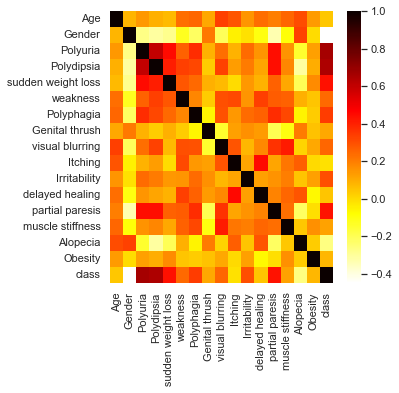

In [12]:
# plotting correlation heatmap
sns.set(rc = {'figure.figsize':(5,5)})
sns.heatmap(modData.corr(), cmap="hot_r", annot=False)

# displaying heatmap
plt.show()

# Machine Learning Models
##### *Decision tree and logistic regression models were built becuase they are good algorithms for small datasets

### Building the decision tree model

In [13]:
# function responsible to create a decision tree based on the dataset you provide
def dtModel(dataset):
    # dividing dataset into X (features, input) and Y (class, output) 
    X = dataset.iloc[:,:len(dataset.columns)-1]
    Y = dataset.iloc[:,len(dataset.columns)-1]
    # splitting dataset intp X and Y train, and X and Y test subsets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    # creating the classification model by building a decision tree
    dt = tree.DecisionTreeClassifier()
    # adjusting weights according to data values so that better accuracy can be achieved
    dt.fit(X_train, Y_train)    
    
    # testing model and printing the classification report (quality of predictions)
    Y_pred = dt.predict(X_test)
    print(metrics.classification_report(Y_test,Y_pred))
    
    # displaying the confusion matrix on a heatmap
    mat = confusion_matrix(Y_test, Y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')

              precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.99      0.95      0.97        86

    accuracy                           0.96       130
   macro avg       0.95      0.97      0.96       130
weighted avg       0.96      0.96      0.96       130



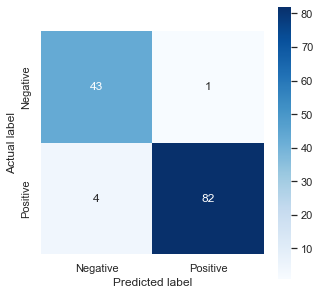

In [14]:
# trying the model
dtModel(modData)

### Decision tree pruning

In [15]:
# measuring k highest scores for each feature to lowering the overfitting
array = modData.values
X = array[:,0:len(modData.columns)-1]
Y = array[:,len(modData.columns)-1]

# Feature extraction
test = SelectKBest(score_func=chi2)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[1.895e-01 3.875e+01 1.162e+02 1.208e+02 5.775e+01 1.272e+01 3.320e+01
 4.914e+00 1.812e+01 4.783e-02 3.533e+01 6.202e-01 5.531e+01 4.875e+00
 2.440e+01 2.250e+00]


In [16]:
# removing featrues that doesn't help in building the tree
dataNew = modData.drop(columns=['Age', 'Itching', 'delayed healing', 'Genital thrush', 'muscle stiffness', 'Obesity'])

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        59
           1       0.92      0.94      0.93        71

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.92       130
weighted avg       0.92      0.92      0.92       130



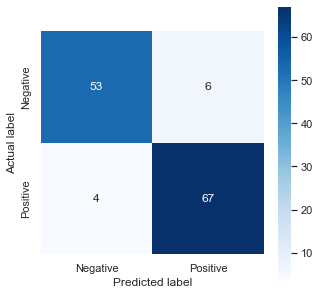

In [17]:
# trying pruned model
dtModel(dataNew)

### Building a logistic regression model

In [18]:
# function responsible to create a logistic regression model based on the dataset you provide
def logReg(dataset):
    # dividing dataset into X (features, input) and Y (class, output) 
    x = dataset.iloc[:,:len(dataset.columns)-1]
    y = dataset.iloc[:,len(dataset.columns)-1]
    
    # splitting dataset intp X and Y train, and X and Y test subsets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
    
    # creating the classification model
    classifier = LogisticRegression(random_state = 0)
    # adjusting weights according to data values so that better accuracy can be achieved
    classifier.fit(x_train, y_train)
    
    # testing model and printing the classification report (quality of predictions)
    y_pred = classifier.predict(x_test)
    print(metrics.classification_report(y_test,y_pred))

    # displaying the confusion matrix on a heatmap
    mat = confusion_matrix(y_test, y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')


              precision    recall  f1-score   support

           0       0.96      0.89      0.93        56
           1       0.92      0.97      0.95        74

    accuracy                           0.94       130
   macro avg       0.94      0.93      0.94       130
weighted avg       0.94      0.94      0.94       130



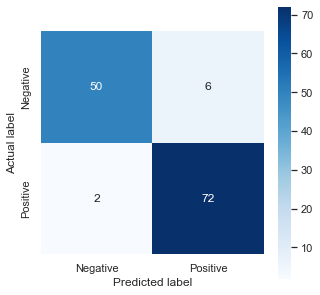

In [19]:
logReg(modData)

### Building a neural network model

In [20]:
# function responsible to create a neural network model based on the dataset you provide
def neuNet(dataset):
    # creating input features and class variables
    X = dataset.iloc[:,0:len(dataset.columns)-1]
    y = dataset.iloc[:,len(dataset.columns)-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=len(dataset.columns)-1))
    #Second  Hidden Layer
    #classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    #Fitting the data to the training dataset
    classifier.fit(X_train,y_train, batch_size=10, epochs=100)
    
    eval_model = classifier.evaluate(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.5)
    
    mat = confusion_matrix(y_test, y_pred)
    labels = ['Negative', 'Positive']
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    #ann_viz(classifier, title="Early stage diabetes risk prediction")

Epoch 1/100
37/37 [==============================] - 1s 3ms/step - loss: 0.6918 - accuracy: 0.5989
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.6236
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.6236
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6779 - accuracy: 0.7033
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.7747
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.9231
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6403 - accuracy: 0.8984
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.8874
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.8764
Epoch 10/100
37/37 [==============================] - 0s 3ms/step - loss: 0.5930 - accuracy: 0.8764
Epoch 11/

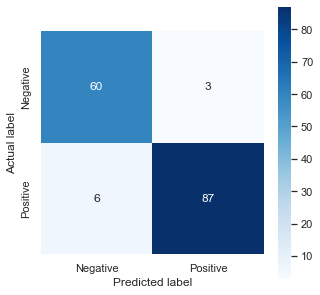

In [21]:
neuNet(modData)